# Final Project: Pnuenomia Classification

In [18]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from kaggle_submission import output_submission_csv
from classifier import Classifier
import scipy
from voc_dataloader import VocDataset, VOC_CLASSES

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reading Pascal Data

### Loading Training Data

In the following cell we will load the training data and also apply some transforms to the data. Feel free to apply more [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) for data augmentation which can lead to better performance. 

In [19]:
# Transforms applied to the training data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize
        ])


In [20]:
ds_train = VocDataset('VOCdevkit_2007/VOC2007/','train',train_transform)

### Loading Validation Data

We will load the test data for the PASCAL VOC 2007 dataset. Do __NOT__ add data augmentation transforms to validation data.

In [21]:
# Transforms applied to the testing data
test_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize,
        ])

In [22]:
ds_val = VocDataset('VOCdevkit_2007/VOC2007/','val',test_transform)

### Visualizing the Data

PASCAL VOC has bounding box annotations in addition to class labels. Use the following code to visualize some random examples and corresponding annotations from the train set. 

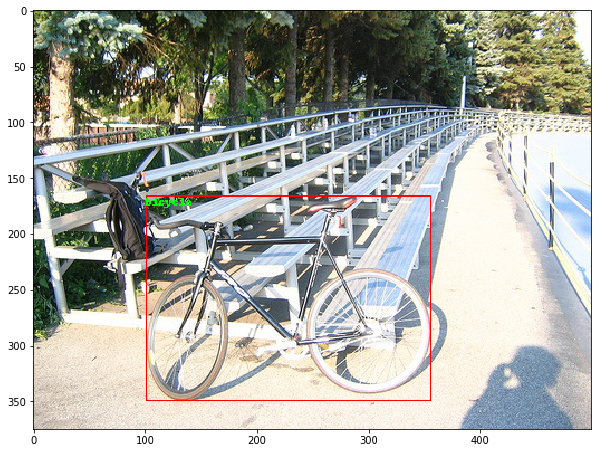

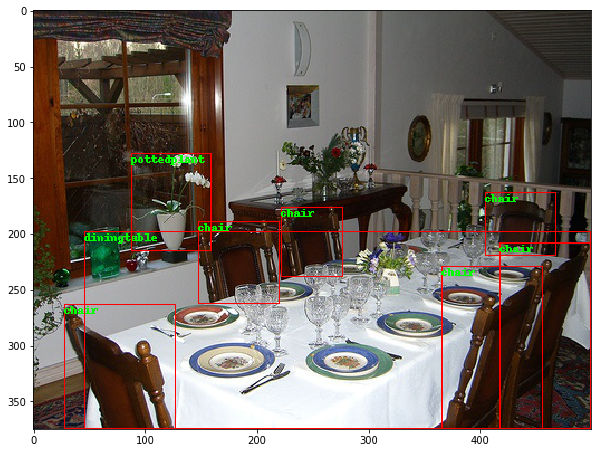

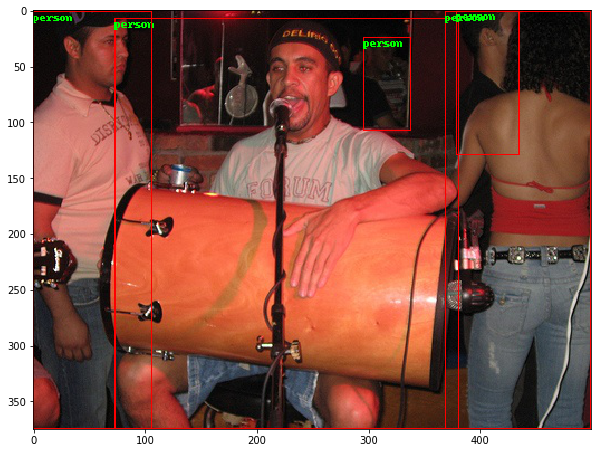

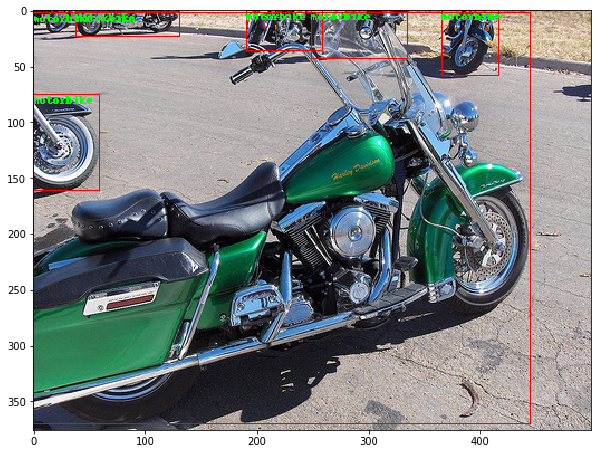

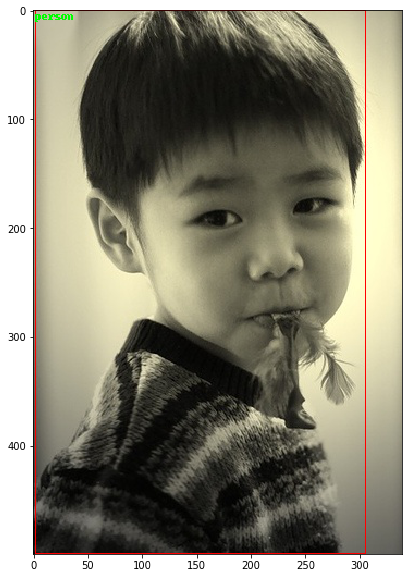

In [23]:
for i in range(5):
    idx = np.random.randint(0, len(ds_train.names)+1)
    _imgpath = os.path.join('VOCdevkit_2007/VOC2007/', 'JPEGImages', ds_train.names[idx]+'.jpg')
    img = Image.open(_imgpath).convert('RGB')
    draw = ImageDraw.Draw(img)
    for j in range(len(ds_train.box_indices[idx])):
        obj = ds_train.box_indices[idx][j]
        draw.rectangle(list(obj), outline=(255,0,0))
        draw.text(list(obj[0:2]), ds_train.classes[ds_train.label_order[idx][j]], fill=(0,255,0))
    plt.figure(figsize = (10,10))
    plt.imshow(np.array(img))

# Classification

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                               batch_size=50, 
                                               shuffle=True,
                                               num_workers=1)

In [26]:
val_loader = torch.utils.data.DataLoader(dataset=ds_val,
                                               batch_size=50, 
                                               shuffle=True,
                                               num_workers=1)

In [27]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels, _) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

In [28]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0,21))
        y_score = np.zeros((0,21))
        for i, (images, labels, _) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss)
        aps = []
        # ignore first class which is background
        for i in range(1, y_true.shape[1]):
            ap = average_precision_score(y_true[:, i], y_score[:, i])
            if print_ind_classes:
                print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(VOC_CLASSES[i], ap))
            aps.append(ap)
            
        aps = np.array(aps)
        mAP = np.mean(aps)
        test_loss = torch.mean(torch.stack(losses))
        print('mAP: {0:.4f}'.format(mAP))
        print('Avg loss: {}'.format(test_loss))
        
    return mAP, test_loss, aps

## Modifying the network 

The network you are given as is will allow you to reach around 0.15-0.2 mAP. To meet the benchmark for this assignment you will need to improve the network. There are a variety of different approaches you should try:

* Network architecture changes
    * Number of layers: try adding layers to make your network deeper
    * Batch normalization: adding batch norm between layers will likely give you a significant performance increase
    * Residual connections: as you increase the depth of your network, you will find that having residual connections like those in ResNet architectures will be helpful
* Optimizer: Instead of plain SGD, you may want to add a learning rate schedule, add momentum, or use one of the other optimizers you have learned about like Adam. Check the `torch.optim` package for other optimizers
* Data augmentation: You should use the `torchvision.transforms` module to try adding random resized crops and horizontal flips of the input data. Check `transforms.RandomResizedCrop` and `transforms.RandomHorizontalFlip` for this
* Epochs: Once you have found a generally good hyperparameter setting try training for more epochs
* Loss function: You might want to add weighting to the `MultiLabelSoftMarginLoss` for classes that are less well represented or experiment with a different loss function



In [29]:
classifier = Classifier().to(device)
# You can can use this function to reload a network you have already saved previously
#classifier.load_state_dict(torch.load('voc_classifier.pth'))

In [30]:
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=45, gamma=0.1)

In [31]:
# Training the Classifier
NUM_EPOCHS = 100
TEST_FREQUENCY = 5

for epoch in range(1, NUM_EPOCHS+1):
    print("Starting epoch number " + str(epoch))
    train_loss = train_classifier(train_loader, classifier, criterion, optimizer)
    print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
    scheduler.step()
    if(epoch%TEST_FREQUENCY==0):
        mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
        print('Evaluating classifier')
        print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
        print("val_loss for Testing on Epoch " +str(epoch) + " is "+ str(val_loss))
        

Starting epoch number 1
Loss for Training on Epoch 1 is 0.44059082865715027
Starting epoch number 2
Loss for Training on Epoch 2 is 0.24151358008384705
Starting epoch number 3
Loss for Training on Epoch 3 is 0.23932667076587677
Starting epoch number 4
Loss for Training on Epoch 4 is 0.23712097108364105
Starting epoch number 5
Loss for Training on Epoch 5 is 0.23767206072807312
-------  Class: aeroplane        AP:   0.0389  -------
-------  Class: bicycle          AP:   0.0708  -------
-------  Class: bird             AP:   0.1162  -------
-------  Class: boat             AP:   0.0332  -------
-------  Class: bottle           AP:   0.0434  -------
-------  Class: bus              AP:   0.0345  -------
-------  Class: car              AP:   0.1187  -------
-------  Class: cat              AP:   0.0811  -------
-------  Class: chair            AP:   0.1241  -------
-------  Class: cow              AP:   0.0431  -------
-------  Class: diningtable      AP:   0.0631  -------
-------  Class:

Loss for Training on Epoch 26 is 0.20418213307857513
Starting epoch number 27
Loss for Training on Epoch 27 is 0.20446735620498657
Starting epoch number 28
Loss for Training on Epoch 28 is 0.1990147978067398
Starting epoch number 29
Loss for Training on Epoch 29 is 0.20350798964500427
Starting epoch number 30
Loss for Training on Epoch 30 is 0.20568148791790009
-------  Class: aeroplane        AP:   0.4379  -------
-------  Class: bicycle          AP:   0.1644  -------
-------  Class: bird             AP:   0.1285  -------
-------  Class: boat             AP:   0.2120  -------
-------  Class: bottle           AP:   0.1300  -------
-------  Class: bus              AP:   0.1028  -------
-------  Class: car              AP:   0.3968  -------
-------  Class: cat              AP:   0.2196  -------
-------  Class: chair            AP:   0.2420  -------
-------  Class: cow              AP:   0.0817  -------
-------  Class: diningtable      AP:   0.1843  -------
-------  Class: dog            

Loss for Training on Epoch 51 is 0.16307735443115234
Starting epoch number 52
Loss for Training on Epoch 52 is 0.16401971876621246
Starting epoch number 53
Loss for Training on Epoch 53 is 0.16016605496406555
Starting epoch number 54
Loss for Training on Epoch 54 is 0.1600799560546875
Starting epoch number 55
Loss for Training on Epoch 55 is 0.16180776059627533
-------  Class: aeroplane        AP:   0.4940  -------
-------  Class: bicycle          AP:   0.2714  -------
-------  Class: bird             AP:   0.1709  -------
-------  Class: boat             AP:   0.2363  -------
-------  Class: bottle           AP:   0.1101  -------
-------  Class: bus              AP:   0.1208  -------
-------  Class: car              AP:   0.4922  -------
-------  Class: cat              AP:   0.2997  -------
-------  Class: chair            AP:   0.3360  -------
-------  Class: cow              AP:   0.1394  -------
-------  Class: diningtable      AP:   0.2480  -------
-------  Class: dog            

Loss for Training on Epoch 76 is 0.14548037946224213
Starting epoch number 77
Loss for Training on Epoch 77 is 0.14533841609954834
Starting epoch number 78
Loss for Training on Epoch 78 is 0.142887145280838
Starting epoch number 79
Loss for Training on Epoch 79 is 0.1407873034477234
Starting epoch number 80
Loss for Training on Epoch 80 is 0.1412738561630249
-------  Class: aeroplane        AP:   0.5133  -------
-------  Class: bicycle          AP:   0.2892  -------
-------  Class: bird             AP:   0.1779  -------
-------  Class: boat             AP:   0.2422  -------
-------  Class: bottle           AP:   0.1028  -------
-------  Class: bus              AP:   0.1149  -------
-------  Class: car              AP:   0.4904  -------
-------  Class: cat              AP:   0.2889  -------
-------  Class: chair            AP:   0.3468  -------
-------  Class: cow              AP:   0.1414  -------
-------  Class: diningtable      AP:   0.2540  -------
-------  Class: dog              A

In [ ]:
# Save the clssifier network
# Suggestion: you can save checkpoints of your network during training and reload them later
torch.save(classifier.state_dict(), './voc_classifier.pth')

# Evaluate on test set



In [ ]:
ds_test = VocDataset('VOCdevkit_2007/VOC2007test/','test', test_transform)

test_loader = torch.utils.data.DataLoader(dataset=ds_test,
                                               batch_size=50, 
                                               shuffle=False,
                                               num_workers=1)

mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)

In [ ]:
output_submission_csv('my_solution.csv', test_aps)